#  Projeto - Will it rain tomorrow?

A pergunta a se fazer: qual o custo do erro na previsão?

In [2]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.model_selection import learning_curve, cross_val_score, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve

from scipy.stats import uniform, gamma, beta, randint
from sklearn.model_selection import RandomizedSearchCV

## Extraindo dados

###  Dados de chuva

In [3]:
rain = pd.read_csv('data_rain/rain_data_aus.csv')

In [ ]:
rain.head()

In [ ]:
rain.info()

In [ ]:
print(rain['date'].min())
print(rain['date'].max())

###  Dados de vento

In [4]:
wind = pd.read_csv('data_rain/wind_table_01.csv')
wind.head()

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0


In [5]:
for i in range(2,9):
    wind = pd.concat([wind, pd.read_csv(f'data_rain/wind_table_0{i}.csv')], ignore_index=True)
    
wind.head()

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wind.info()

In [6]:
cont = 2
for col in wind.columns[8:14]:
    wind.loc[~wind[col].isnull(), wind.columns[cont]] = wind.loc[~wind[col].isnull(), col]
    cont +=1
    
wind = wind.drop(['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm'], axis=1)

In [ ]:
wind.info()

###  Agregando duas tabelas

In [7]:
df = pd.merge(left=rain, right=wind, how='left', on=['date', 'location'])

In [ ]:
df.shape

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164386 entries, 0 to 164385
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              164386 non-null  datetime64[ns]
 1   location          164386 non-null  object        
 2   mintemp           163614 non-null  float64       
 3   maxtemp           163989 non-null  float64       
 4   rainfall          162767 non-null  float64       
 5   evaporation       90128 non-null   float64       
 6   sunshine          80607 non-null   float64       
 7   humidity9am       162352 non-null  float64       
 8   humidity3pm       159262 non-null  float64       
 9   pressure9am       148085 non-null  float64       
 10  pressure3pm       148113 non-null  float64       
 11  cloud9am          100879 non-null  float64       
 12  cloud3pm          95716 non-null   float64       
 13  temp9am           163410 non-null  float64       
 14  temp

##  Tratamento dos dados

In [8]:
# Atenção: aqui, os dados nulos foram preenchidos com 0 (Negação)
df['raintoday'] = df['raintoday'].apply(lambda x: 1 if x == 'Yes' else 0)

In [9]:
df['raintomorrow'] = df['raintomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [10]:
df['date'] = pd.to_datetime(df['date'])

### Adicionando coluna de estação do ano

Na Austrália:

Verão: Dezembro a Fevereiro

Outono: Março a Maio

Inverno: Junho a Agosto

Primavera: Setembro a Novembro

In [11]:
def estacao(mes):
    ''' Esta funcao recebe um inteiro referente ao mes do ano e retorna 
        uma string referente a estacao do ano na Australia
        
        Input:
            mes - int mes do ano
        Output:
            estacao - str estacao do ano
    '''
    
#    print(mes)
    
    if mes<=2 or mes==12:
        return 'summer'
    elif mes>=3 and mes<=5:
        return 'autumn'
    elif mes>=6 and mes<=8:
        return 'winter'
    elif mes>=9 and mes<=11:
        return 'spring'
    else:
        return None

In [12]:
df['season'] = df['date'].dt.month.apply(estacao)

###  Adicionando coluna de estado

Nota: as cidade/localidades relacionadas ao Australian Capital Territory e Norfolk Island foram incluídos no estado
de New South Wales, pelas características climáticas parecidas.

In [46]:
state = pd.read_csv('data_rain/au_state.csv')

In [64]:
df['state'] = df['location'].apply(lambda x: state[state['city']==x].admin.values[0])

###  Criando pipeline de pré-processamento

In [67]:
num_columns = list(df.select_dtypes(exclude='object').columns)

remove_col = ['date', 'raintomorrow', 'amountOfRain', 'modelo_vigente', 'temp', 'temp9am', 'temp3pm', 'humidity']

num_columns = [col for col in num_columns if col not in remove_col]
num_columns

['mintemp',
 'maxtemp',
 'rainfall',
 'evaporation',
 'sunshine',
 'humidity9am',
 'humidity3pm',
 'pressure9am',
 'pressure3pm',
 'cloud9am',
 'cloud3pm',
 'raintoday',
 'precipitation3pm',
 'precipitation9am',
 'wind_gustspeed',
 'wind_speed9am',
 'wind_speed3pm']

In [68]:
cat_columns = list(df.select_dtypes('object').columns)
cat_columns.remove('location')
cat_columns

['wind_gustdir', 'wind_dir9am', 'wind_dir3pm', 'season', 'state']

In [69]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinalencoder = OrdinalEncoder()
onehotencoder = OneHotEncoder(drop='first',  handle_unknown='error')
cat_imputer = SimpleImputer(strategy='most_frequent')

#labelencoder = LabelEncoder()
#encoder.fit(df['wind_gustdir'])

#df['wind_gustdir'] = encoder.transform(df['wind_gustdir'])
#df['wind_dir9am'] = encoder.transform(df['wind_dir9am'])
#df['wind_dir3pm'] = encoder.transform(df['wind_dir3pm'])

In [70]:
categorical_pipeline = Pipeline(steps=[('missing', cat_imputer),
                                       ('encode', ordinalencoder)])

In [71]:
from sklearn.preprocessing import StandardScaler

numerical_imputer = SimpleImputer()
scaler = StandardScaler()

In [72]:
numerical_pipeline = Pipeline(steps=[('missing', numerical_imputer),
                                     ('standardize', scaler)])

In [73]:
from sklearn.compose import ColumnTransformer

dataprep = ColumnTransformer(transformers=[('numerical_transform', numerical_pipeline, num_columns),
                                           ('categ_transform', categorical_pipeline, cat_columns)])

##  Análise de correlação de colunas

In [ ]:
# Analisando as colunas de temperatura, não há necessidade de se utilizar todas as colunas, pois, por exemplo,
# observa-se uma grande correlação entre 'mintemp' e 'temp9am' e entre 'maxtemp' e 'temp3pm'. Logo, pode-se utilizar
# apenas uma de cada. No caso de 'temp', os valore da coluna estão fora do intervalo entre 'mintemp' e 'maxtemp'.
# Por isso, essa coluna não será utilizada.

df[['mintemp', 'maxtemp', 'temp', 'temp9am', 'temp3pm']]

In [ ]:
df[['mintemp', 'maxtemp', 'temp', 'temp9am', 'temp3pm', 'raintomorrow']].corr()

In [ ]:
# Analogamente à análise de temperatura, observa-se que as colunas de 'humidity' e 'humidity3pm' têm alta
# correlação. Portanto, apenas uma delas será utilizada.

df[['humidity9am', 'humidity3pm', 'humidity']].corr()

In [ ]:
sns.distplot(df['humidity'], color='blue')
sns.distplot(df['humidity9am'], color='red')
sns.distplot(df['humidity3pm'], color='orange');

##  Outras análises

###  Coluna 'amountOfRain'

Na realidade, a coluna 'amountOfRain' representa um vazamento de dados

In [ ]:
df[['amountOfRain', 'raintomorrow']].groupby('raintomorrow').agg(['min', 'max'])

In [ ]:
df[['amountOfRain', 'raintoday']].groupby('raintoday').agg(['min', 'max'])

In [ ]:
df[['rainfall', 'raintoday']].groupby('raintoday').agg(['min', 'max'])

###  Coluna 'humidity3pm'

Aqui concluimos que a coluna 'humidity3pm' tem alta correlação com a coluna 'raintomorrow', a coluna target.

In [ ]:
sns.boxplot(x=df['raintomorrow'], y=df['humidity3pm'])

###  Colunas de wind_speed

Aqui investigamos se as colunas têm alta correlação

In [ ]:
sns.distplot(df['wind_gustspeed'], color='blue')
sns.distplot(df['wind_speed9am'], color='red')
sns.distplot(df['wind_speed3pm'], color='orange')

###  Analisando coluna 'location'

In [20]:
df['raintomorrow'].groupby(df['location']).sum()

location
Adelaide             795
Albany              1053
Albury               715
AliceSprings         284
BadgerysCreek        664
Ballarat             911
Bendigo              661
Brisbane             794
Cairns              1092
Canberra             719
Cobar                457
CoffsHarbour         994
Dartmoor            1075
Darwin               982
GoldCoast            871
Hobart               876
Katherine            347
Launceston           812
Melbourne            749
MelbourneAirport     767
Mildura              380
Moree                462
MountGambier        1077
MountGinini          954
Newcastle            838
Nhil                 325
NorahHead            934
NorfolkIsland       1060
Nuriootpa            705
PearceRAAF           603
Penrith              671
Perth                758
PerthAirport         664
Portland            1275
Richmond             646
Sale                 728
SalmonGums           550
Sydney               986
SydneyAirport        887
Townsville      

In [21]:
df['raintomorrow'].groupby(df['location']).count()

location
Adelaide            3549
Albany              3463
Albury              3467
AliceSprings        3484
BadgerysCreek       3371
Ballarat            3489
Bendigo             3491
Brisbane            3618
Cairns              3402
Canberra            3877
Cobar               3437
CoffsHarbour        3414
Dartmoor            3404
Darwin              3653
GoldCoast           3423
Hobart              3650
Katherine           2010
Launceston          3486
Melbourne           2857
MelbourneAirport    3470
Mildura             3468
Moree               3315
MountGambier        3482
MountGinini         3367
Newcastle           3402
Nhil                2031
NorahHead           3390
NorfolkIsland       3382
Nuriootpa           3461
PearceRAAF          3216
Penrith             3414
Perth               3655
PerthAirport        3471
Portland            3456
Richmond            3411
Sale                3457
SalmonGums          3414
Sydney              3798
SydneyAirport       3463
Townsville      

###  Analisando coluna 'modelo_vigente'

O modelo baseline que será utilizado é o utilizado na coluna 'modelo_vigente'

In [ ]:
plt.scatter(df.index, df['modelo_vigente'].sort_values())

In [ ]:
y_vig = [1 if i>0.5 else 0 for i in df['modelo_vigente']]
print(precision_score(y_vig, y))
print(recall_score(y_vig, y))
print(f1_score(y_vig, y))
print(roc_auc_score(y, df['modelo_vigente']))

##  Separando treino e teste

In [74]:
X = df.drop('raintomorrow', axis=1)
y = df['raintomorrow']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=35, stratify=y)

In [ ]:
df.isnull().sum()

In [ ]:
X2 = df[['mintemp', 'maxtemp', 'rainfall', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'precipitation3pm', 'wind_gustspeed', 'wind_speed9am', 'wind_speed3pm']]

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=35, stratify=y)

##  Escolha do modelo

In [76]:
from lightgbm import LGBMClassifier, plot_importance

model_lgbm = LGBMClassifier(max_depth=4, n_estimators=70, colsample_bytree=.7, n_jobs=-1)
lgbm = LGBMClassifier()

In [ ]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(max_iter=300)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging = BaggingClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=3), 
            n_estimators=100)

model_tree = DecisionTreeClassifier(max_depth=5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=5, n_estimators=70, n_jobs=-1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20)

In [77]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modelling', model_lgbm)
                          ])

pipeline.fit(X_train, y_train);

In [ ]:
pipeline2 = Pipeline(steps=[('preprocessing', dataprep),
                           ('modelling', model_log)
                          ])

pipeline2.fit(X_train, y_train);

In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(pipeline, X_test, y_test, ax=ax, name='LGBM')
plot_roc_curve(pipeline2, X_test, y_test, ax=ax, name='Other')

In [84]:
print(roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1]))
print(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]))

0.8810015155398283
0.8764192385882259


In [ ]:
cross_val_score(pipeline2, X_train, y_train, cv=KFold(n_splits=5), scoring='precision')

In [85]:
cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=5), scoring='precision')

array([0.75282438, 0.76016124, 0.74948735, 0.74916388, 0.75502681])

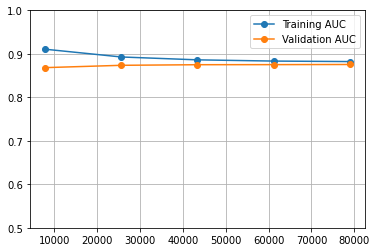

In [87]:
curves = learning_curve(pipeline, X_train, y_train, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Validation AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

##  Escolhendo colunas

In [78]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [96]:
print(len(num_columns))
print(len(cat_columns))

17
5


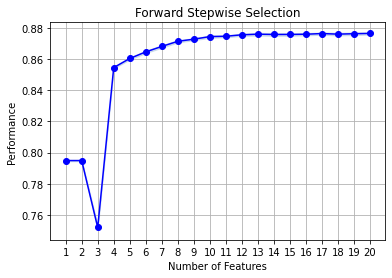

In [79]:
selector_f = SFS(pipeline.named_steps['modelling'], k_features=20, scoring='roc_auc')
selector_f.fit(pipeline.named_steps['preprocessing'].fit_transform(X_train), y_train)

fig = plot_sfs(selector_f.get_metric_dict(), kind='std_err')
plt.title('Forward Stepwise Selection')
plt.grid()
plt.show()

In [80]:
selector_f.get_metric_dict()[10]['avg_score']

0.8742905430837276

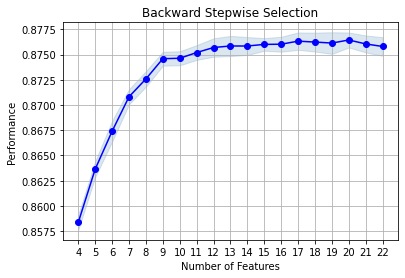

In [81]:
selector = SFS(pipeline.named_steps['modelling'], forward=False, k_features=4, scoring='roc_auc')
selector.fit(pipeline.named_steps['preprocessing'].fit_transform(X_train), y_train)

fig = plot_sfs(selector.get_metric_dict(), kind='std_err')
plt.title('Backward Stepwise Selection')
plt.grid()
plt.show()

In [82]:
selector.get_metric_dict()[12]['avg_score']

0.8756926701994028

In [83]:
print([(num_columns + cat_columns)[i] for i in selector.get_metric_dict()[12]['feature_idx']])
print([(num_columns + cat_columns)[i] for i in selector_f.get_metric_dict()[12]['feature_idx']])

['maxtemp', 'rainfall', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure3pm', 'cloud3pm', 'wind_gustspeed', 'wind_speed3pm', 'wind_dir9am', 'wind_dir3pm', 'state']
['maxtemp', 'rainfall', 'sunshine', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud3pm', 'wind_gustspeed', 'wind_speed3pm', 'wind_dir9am', 'wind_dir3pm', 'state']


In [95]:
cat_columns

['wind_gustdir', 'wind_dir9am', 'wind_dir3pm', 'season', 'state']

In [97]:
num_sazo_col = [(num_columns + cat_columns)[i] for i in selector_f.get_metric_dict()[12]['feature_idx'] if i < 17]
num_sazo_col.remove('sunshine')
num_sazo_col.remove('cloud3pm')
cat_sazo_col = [(num_columns + cat_columns)[i] for i in selector_f.get_metric_dict()[12]['feature_idx'] if i >= 17 and i<21]

loc_pipeline = Pipeline(steps=[('missing', cat_imputer),
                                 ('encode', onehotencoder)])

dataprep_sazo = ColumnTransformer(transformers=[('numerical_transform', numerical_pipeline, num_sazo_col),
                                                ('categ_transform', categorical_pipeline, cat_sazo_col),
                                                ('loc_transform', loc_pipeline, ['state'])])

In [98]:
pipeline_sazo = Pipeline(steps=[('preprocessing', dataprep_sazo),
                                ('modelling', model_lgbm)
                               ])
pipeline_sazo.fit(X_train, y_train);

In [99]:
cross_val_score(pipeline_sazo, X_train, y_train, cv=KFold(n_splits=5), scoring='roc_auc')

array([0.86817281, 0.86651543, 0.86720509, 0.8632345 , 0.86800917])

In [100]:
cross_val_score(pipeline_sazo, X_train, y_train, cv=KFold(n_splits=5), scoring='precision')

array([0.7407668 , 0.75378267, 0.7453966 , 0.73941037, 0.74601525])

In [ ]:
pipeline_sazo.named_steps['preprocessing'].fit_transform(X_train)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

ValueError: Number of features of the model must match the input. Model n_features_ is 16 and input n_features is 22 

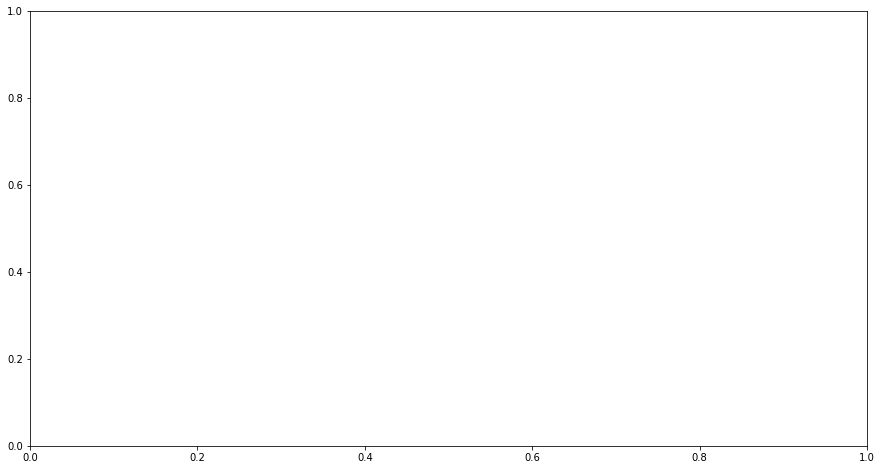

In [120]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_partial_dependence(pipeline.named_steps['modelling'], 
                        pipeline.named_steps['preprocessing'].fit_transform(X_test), 
                        features=X_train.columns, 
                        feature_names=X_train.columns,
                        grid_resolution=100, ax = ax)

##  Tunando os parâmetros

In [ ]:
pipeline3 = Pipeline(steps=[('preprocessing', dataprep_sazo),
                           ('modelling', lgbm)
                          ])

In [ ]:
param_dist = {'preprocessing__numerical_transform__missing__strategy': ['mean','median'],
              'modelling__boosting_type': ['gbdt','dart','goss','rf'],
              'modelling__num_leaves': randint(3,8),
              'modelling__max_depth': randint(1,5),
#              'modelling__learning_rate': gamma(1, loc=0, scale=0.1),
              'modelling__n_estimators': randint(10,100),
              'modelling__colsample_bytree': beta(2, 1, loc=0, scale=1)#,
#              'modelling__reg_alpha': gamma(.5, loc=0, scale=0.5),
#              'modelling__reg_lambda': gamma(.5, loc=0, scale=0.5)
             }

n_iter_search = 100
random_search = RandomizedSearchCV(pipeline3, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   verbose=True, 
                                   cv=KFold(n_splits=5, shuffle=True),
                                   scoring='precision',
                                   random_state=27,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1])

In [ ]:
cross_val_score(random_search.best_estimator_, X_train, y_train, cv=KFold(n_splits=5), scoring='precision')

In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(pipeline, X_test, y_test, ax=ax, name='LGBM')
plot_roc_curve(random_search.best_estimator_, X_test, y_test, ax=ax, name='Tuned')

In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(pipeline_sazo, X_test, y_test, ax=ax, name='LGBM')
plot_roc_curve(random_search.best_estimator_, X_test, y_test, ax=ax, name='Tuned')

In [ ]:
print(precision_score(random_search.best_estimator_.predict(X_test), y_test))
print(recall_score(random_search.best_estimator_.predict(X_test), y_test))
print(f1_score(random_search.best_estimator_.predict(X_test), y_test))

In [ ]:
print(precision_score(random_search.best_estimator_.predict(X_train), y_train))
print(recall_score(random_search.best_estimator_.predict(X_train), y_train))
print(f1_score(random_search.best_estimator_.predict(X_train), y_train))

In [ ]:
(random_search.best_estimator_.predict_proba(X_test)[:,1]>0.3).sum()

##  Trabalhando com dados sazonais

Na Austrália:

Verão: Dezembro a Fevereiro

Outono: Março a Maio

Inverno: Junho a Agosto

Primavera: Setembro a Novembro

In [101]:
X_verao = df.loc[(df['date'].dt.month<=2) | (df['date'].dt.month==12), :].drop('raintomorrow', axis=1)
X_verao = X_verao.reset_index()

y_verao = df.loc[(df['date'].dt.month<=2) | (df['date'].dt.month==12), 'raintomorrow']
y_verao = y_verao.reset_index()

In [102]:
X_verao = X_verao.drop('index', axis=1)
y_verao = y_verao.drop('index', axis=1)

In [103]:
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(X_verao, np.ravel(y_verao), test_size=0.15, random_state=35, stratify=y_verao)

In [ ]:
X_outono = df.loc[(df['date'].dt.month<=5) & (df['date'].dt.month>=3), :].drop('raintomorrow', axis=1)
X_outono = X_outono.reset_index()

y_outono = df.loc[(df['date'].dt.month<=5) & (df['date'].dt.month>=3), 'raintomorrow']
y_outono = y_outono.reset_index()

In [ ]:
X_outono = X_outono.drop('index', axis=1)
y_outono = y_outono.drop('index', axis=1)

In [ ]:
X_o_train, X_o_test, y_o_train, y_o_test = train_test_split(X_outono, np.ravel(y_outono), test_size=0.15, random_state=35, stratify=y_outono)

In [ ]:
X_inverno = df.loc[(df['date'].dt.month<=8) & (df['date'].dt.month>=6), :].drop('raintomorrow', axis=1)
X_inverno = X_inverno.reset_index()

y_inverno = df.loc[(df['date'].dt.month<=8) & (df['date'].dt.month>=6), 'raintomorrow']
y_inverno = y_inverno.reset_index()

In [ ]:
X_inverno = X_inverno.drop('index', axis=1)
y_inverno = y_inverno.drop('index', axis=1)

In [ ]:
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_inverno, np.ravel(y_inverno), test_size=0.15, random_state=35, stratify=y_inverno)

In [ ]:
X_primavera = df.loc[(df['date'].dt.month<=11) & (df['date'].dt.month>=9), :].drop('raintomorrow', axis=1)
X_primavera = X_primavera.reset_index()

y_primavera = df.loc[(df['date'].dt.month<=11) & (df['date'].dt.month>=9), 'raintomorrow']
y_primavera = y_primavera.reset_index()

In [ ]:
X_primavera = X_primavera.drop('index', axis=1)
y_primavera = y_primavera.drop('index', axis=1)

In [ ]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_primavera, np.ravel(y_primavera), test_size=0.15, random_state=35, stratify=y_primavera)

###  Treinando o modelo dos dados de verão

In [104]:
modelo_verao = pipeline_sazo.fit(X_v_train, y_v_train)

In [105]:
roc_auc_score(y_v_test, modelo_verao.predict_proba(X_v_test)[:,1])

0.8674714401873308

In [106]:
cross_val_score(pipeline_sazo, X_v_train, y_v_train, scoring='roc_auc', cv=KFold(n_splits=5, shuffle=True))

array([0.87094147, 0.86684032, 0.87032934, 0.87161618, 0.86321508])

In [107]:
print(precision_score(modelo_verao.predict(X_v_test), y_v_test))
print(recall_score(modelo_verao.predict(X_v_test), y_v_test))
print(f1_score(modelo_verao.predict(X_v_test), y_v_test))

0.4454855195911414
0.7428977272727273
0.556975505857295


In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(pipeline_sazo, X_v_train, y_v_train, ax=ax)
plot_roc_curve(pipeline_sazo, X_v_test, y_v_test, ax=ax)

In [ ]:
curves = learning_curve(pipeline_sazo, X_p_train, y_p_train, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Validation AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

##  Ajustando threshold

In [118]:
y_pred = [1 if i>0.2 else 0 for i in pipeline_sazo.predict_proba(X_test)[:,1]]

In [119]:
print(precision_score(y_pred, y_test))
print(recall_score(y_pred, y_test))
print(f1_score(y_pred, y_test))

0.7302112153316688
0.5286272594040059
0.6132789254441894


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)